In [1]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from data_utils import *

Matplotlib is building the font cache; this may take a moment.


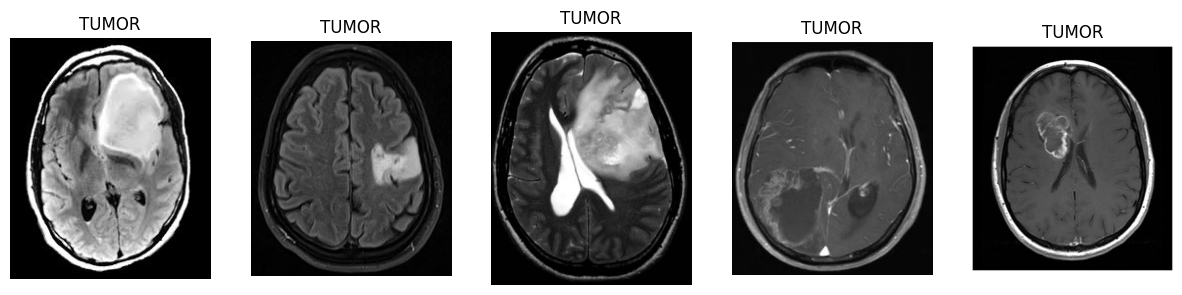

In [2]:
show_images('dataset/yes', title='TUMOR', num_images=5)

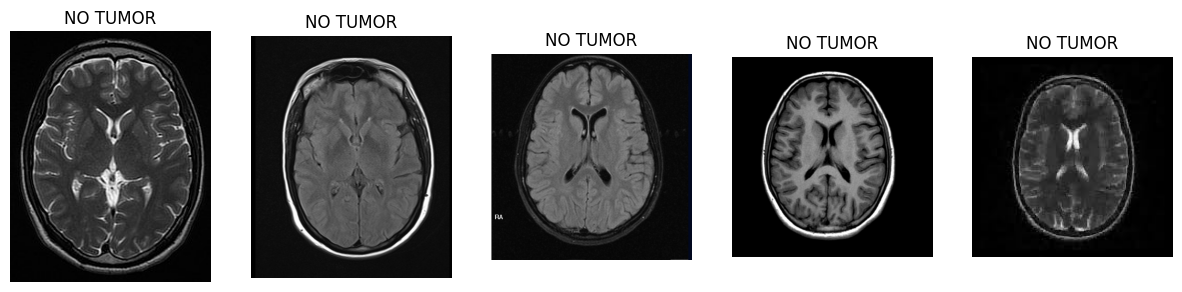

In [3]:
show_images('dataset/no', title='NO TUMOR', num_images=5)

In [4]:
IMG_SIZE = 128

tumor_dir = 'dataset/yes'
no_tumor_dir = 'dataset/no'

tumor_images, tumor_labels = preprocess_and_label_data(tumor_dir, 1, IMG_SIZE)
no_tumor_images, no_tumor_labels = preprocess_and_label_data(no_tumor_dir, 0, IMG_SIZE)

# Combine datasets
X = np.array(tumor_images + no_tumor_images)  # Features (images)
y = np.array(tumor_labels + no_tumor_labels)

X = np.array([apply_clahe(img) for img in X])

In [5]:

# Reshape to add the channel dimension
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Shape: (num_samples, 128, 128, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Training set: {X_val.shape}, Labels: {y_val.shape}")


Training set: (202, 128, 128, 1), Labels: (202,)
Training set: (51, 128, 128, 1), Labels: (51,)


In [6]:

# Define the CNN model
model = Sequential([
    # First Conv layer
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    # Second Conv layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Third Conv layer
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Flatten the features
    Flatten(),
    
    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevents overfitting
    Dense(1, activation='sigmoid')  # Binary classification (Tumor or No Tumor)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Print model summary
model.summary()

c:\Users\noah-\brain_tumor_detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=10)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5660 - loss: 0.6875 - val_accuracy: 0.7059 - val_loss: 0.5503
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.7635 - loss: 0.5042 - val_accuracy: 0.7843 - val_loss: 0.5520
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.8219 - loss: 0.4673 - val_accuracy: 0.8039 - val_loss: 0.5526
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8497 - loss: 0.4308 - val_accuracy: 0.6863 - val_loss: 0.5611
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8279 - loss: 0.4587 - val_accuracy: 0.7451 - val_loss: 0.5115
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8374 - loss: 0.3268 - val_accuracy: 0.8039 - val_loss: 0.4507
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8845 - loss: 0.2410 - val_accuracy: 0.8627 - val_loss: 0.3795
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8932 - loss: 0.2362 - val_accuracy: 0.7843 - v

In [8]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8903 - loss: 0.6887
Validation Accuracy: 88.24%


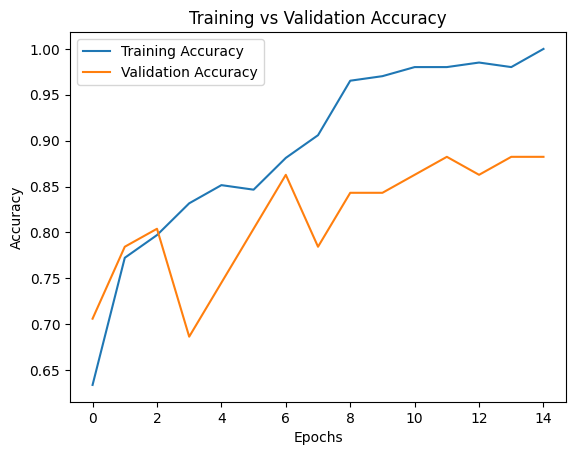

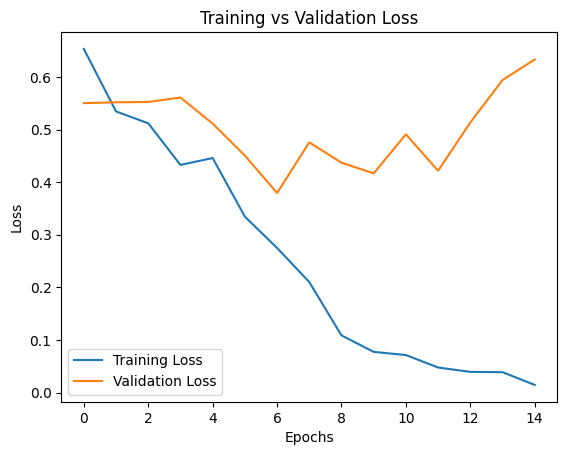

In [9]:
plot_model_info(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


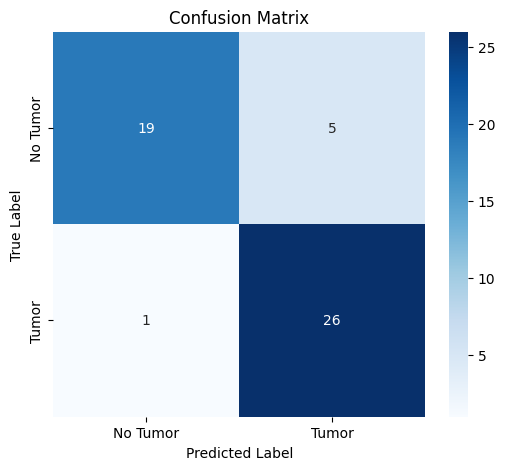


📄 Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.95      0.79      0.86        24
       Tumor       0.84      0.96      0.90        27

    accuracy                           0.88        51
   macro avg       0.89      0.88      0.88        51
weighted avg       0.89      0.88      0.88        51



In [10]:


# Predict class labels
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_val, y_pred, target_names=["No Tumor", "Tumor"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


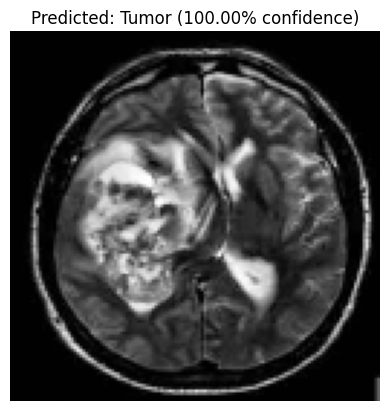

In [14]:
# Give a new input

image_folder = 'dataset/yes'

image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

random_image = random.choice(image_files)

random_image_path = os.path.join(image_folder, random_image)

predict_image(model, random_image_path, 128)